In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a global line width for all plots
plt.rcParams['lines.linewidth'] = 0.5

In [89]:
fstart = 1e9
fstop = 0.5e11
fpoints = 500
f = np.linspace(fstart, fstop, fpoints)
l = 6e-6 / 16

R_odd = np.linspace(0.8e6, 3.2e6, fpoints)
L_odd = (0.3 * np.exp(-f / f[0]) + 3.8) * 1e-7
G_odd = np.linspace(0, 60e-1, fpoints)
C_odd = np.linspace(1.5e-10, 1.4e-10, fpoints)

R_even = R_odd/1.3
L_even = L_odd/1.1
G_even = G_odd/1.5
C_even = C_odd/1.5
Cst = 10*C_odd

In [90]:
def invert_mat(A):
    M, N, P = A.shape
    inv_A = np.zeros((M, N, P), dtype=complex)
    for i in range(P):
        inv_A[:, :, i] = np.linalg.inv(A[:, :, i])
    return inv_A

def multiply_mat(A, B):
    M, N, P = A.shape
    C = np.zeros((M, N, P), dtype=complex)
    for i in range(P):
        C[:, :, i] = np.dot(A[:, :, i], B[:, :, i])
    return C

In [91]:
def gamma_Z0(R_odd, L_odd, G_odd, C_odd, R_even, L_even, G_even, C_even, Cst, f, l):
    w = 2 * np.pi * f

    gamma_odd_off = np.sqrt((1j * w * L_odd + R_odd) * (1j * w * C_odd + G_odd))
    gamma_even_off = np.sqrt((1j * w * L_even + R_even) * (1j * w * C_even + G_even))
    Z0_odd_off = np.sqrt((R_odd + 1j * w * L_odd) / (G_odd + 1j * w * C_odd))
    Z0_even_off = np.sqrt((R_even + 1j * w * L_even) / (G_even + 1j * w * C_even))
    theta_odd_off = gamma_odd_off * l
    theta_even_off = gamma_even_off * l

    gamma_odd_on = np.sqrt((1j * w * L_odd + R_odd) * (1j * w * (C_odd + Cst) + G_odd))
    gamma_even_on = np.sqrt((1j * w * L_even + R_even) * (1j * w * C_even + G_even))
    Z0_odd_on = np.sqrt((R_odd + 1j * w * L_odd) / (G_odd + 1j * w * (C_odd + Cst)))
    Z0_even_on = np.sqrt((R_even + 1j * w * L_even) / (G_even + 1j * w * C_even))
    theta_odd_on = gamma_odd_on * l
    theta_even_on = gamma_even_on * l

    return (gamma_odd_off, gamma_even_off, Z0_odd_off, Z0_even_off, theta_odd_off, theta_even_off,
            gamma_odd_on, gamma_even_on, Z0_odd_on, Z0_even_on, theta_odd_on, theta_even_on)

In [92]:
def create_Z_matrix(Z0_even, csc_theta_even, cot_theta_even, Z0_odd, csc_theta_odd, cot_theta_odd):
    Z11 = -(1j/2) * (Z0_even * cot_theta_even + Z0_odd * cot_theta_odd)
    Z12 = -(1j/2) * (Z0_even * cot_theta_even - Z0_odd * cot_theta_odd)
    Z13 = -(1j/2) * (Z0_even * csc_theta_even - Z0_odd * csc_theta_odd)
    Z14 = -(1j/2) * (Z0_even * csc_theta_even + Z0_odd * csc_theta_odd)

    Z = np.zeros((4, 4, len(Z11)), dtype=complex)

    Z[0, 0, :] = Z11
    Z[1, 1, :] = Z11
    Z[2, 2, :] = Z11
    Z[3, 3, :] = Z11

    Z[0, 1, :] = Z12
    Z[1, 0, :] = Z12
    Z[2, 3, :] = Z12
    Z[3, 2, :] = Z12

    Z[0, 2, :] = Z13
    Z[2, 0, :] = Z13
    Z[1, 3, :] = Z13
    Z[3, 1, :] = Z13

    Z[0, 3, :] = Z14
    Z[3, 0, :] = Z14
    Z[1, 2, :] = Z14
    Z[2, 1, :] = Z14

    return Z

def Zparameters10(Z0_odd_off, Z0_even_off, Z0_odd_on, Z0_even_on, theta_odd_off, theta_even_off, theta_odd_on, theta_even_on):
    cot_theta_odd_off = 1 / np.tan(theta_odd_off)
    cot_theta_odd_on = 1 / np.tan(theta_odd_on)
    cot_theta_even_off = 1 / np.tan(theta_even_off)
    cot_theta_even_on = 1 / np.tan(theta_even_on)

    csc_theta_odd_off = 1 / np.sin(theta_odd_off)
    csc_theta_odd_on = 1 / np.sin(theta_odd_on)
    csc_theta_even_off = 1 / np.sin(theta_even_off)
    csc_theta_even_on = 1 / np.sin(theta_even_on)

    Z_off = create_Z_matrix(Z0_even_off, csc_theta_even_off, cot_theta_even_off, Z0_odd_off, csc_theta_odd_off, cot_theta_odd_off)
    Z_on = create_Z_matrix(Z0_even_on, csc_theta_even_on, cot_theta_even_on, Z0_odd_on, csc_theta_odd_on, cot_theta_odd_on)

    return Z_on, Z_off

In [ ]:
def plot_Z_params(f, Z, title):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_Z_params, axs = plt.subplots(gridSize, gridSize, figsize=(12, 9))

    for i in range(16):
        ax = axs[i // gridSize, i % gridSize]
        ax.semilogx(f, np.real(Z[i // 4, i % 4, :]))
        ax.semilogx(f, np.imag(Z[i // 4, i % 4, :]))
        ax.grid(True)

    fig_Z_params.suptitle(title, fontsize=16)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def plot_S_parameters(f, S_off, S_on, title, smooth_window=1):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 9))

    for i in range(16):
        # Smooth the S-parameter data
        smoothed_S_off = moving_average(20*np.log10(np.abs(S_off[int(i/4), i%4, :])), smooth_window)
        smoothed_S_on = moving_average(20*np.log10(np.abs(S_on[int(i/4), i%4, :])), smooth_window)
        line, = ax.flat[i].semilogx(f[:len(smoothed_S_off)], smoothed_S_off)
        line, = ax.flat[i].semilogx(f[:len(smoothed_S_on)], smoothed_S_on)
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)

def plot_ABCD(ABCD, f, title):
    # Extracting matrices A, B, C, D
    A = ABCD[0, 0, :]
    B = ABCD[0, 1, :]
    C = ABCD[1, 0, :]
    D = ABCD[1, 1, :]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    axes[0].semilogx(f, np.real(A))
    axes[0].semilogx(f, np.imag(A))
    axes[0].grid(True)
    axes[1].semilogx(f, np.real(B))
    axes[1].semilogx(f, np.imag(B))
    axes[1].grid(True)
    axes[2].semilogx(f, np.real(C))
    axes[2].semilogx(f, np.imag(C))
    axes[2].grid(True)
    axes[3].semilogx(f, np.real(D))
    axes[3].semilogx(f, np.imag(D))
    axes[3].grid(True)

    fig.suptitle(title, fontsize=16)

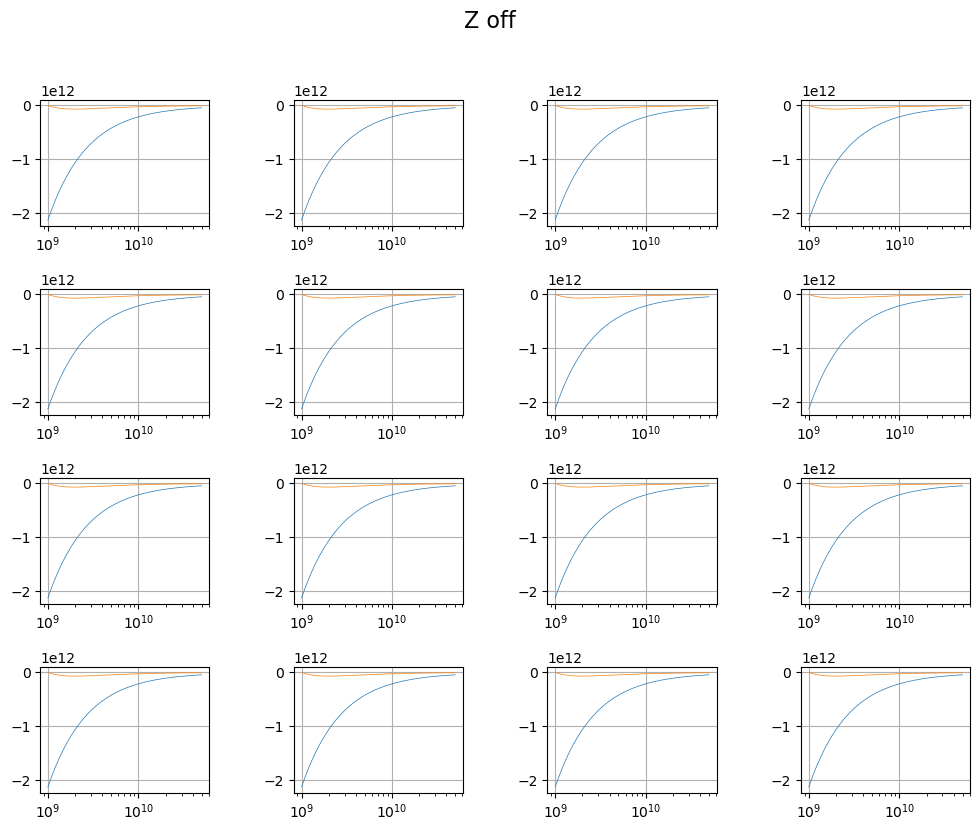

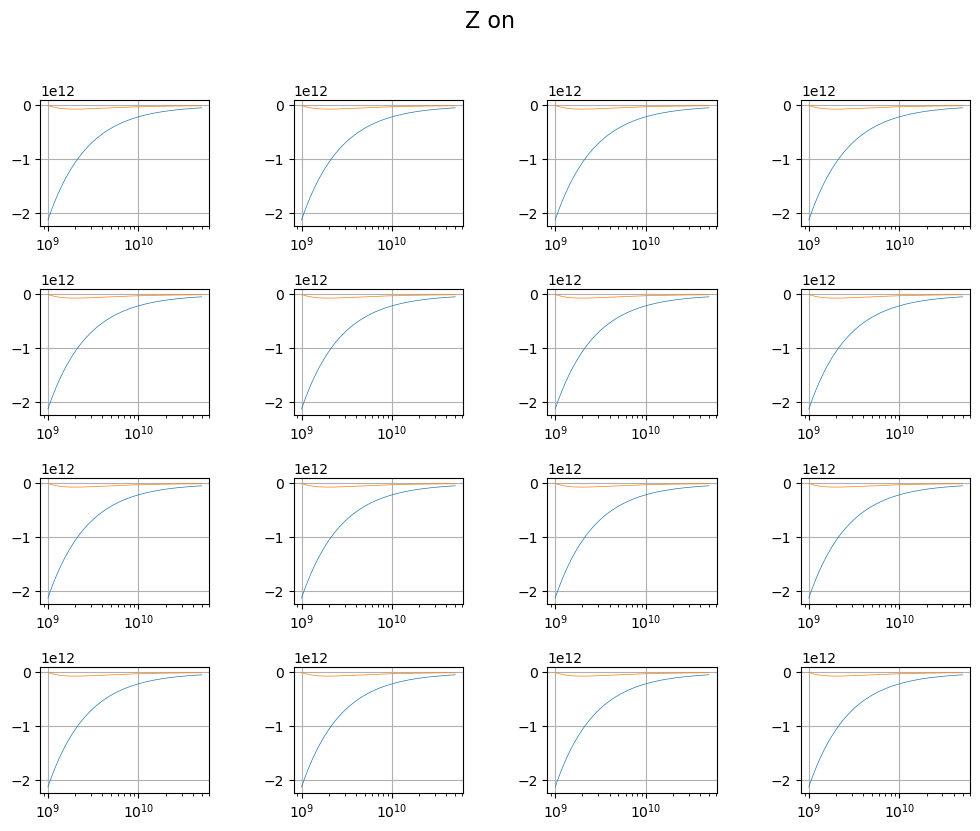

In [93]:
gamma_odd_off, gamma_even_off, Z0_odd_off, Z0_even_off, theta_odd_off, theta_even_off, \
gamma_odd_on, gamma_even_on, Z0_odd_on, Z0_even_on, theta_odd_on, theta_even_on = gamma_Z0(R_odd, L_odd, G_odd, C_odd, R_even, L_even, G_even, C_even, Cst, f, l)

Z_on, Z_off = Zparameters10(Z0_odd_off, Z0_even_off, Z0_odd_on, Z0_even_on, theta_odd_off, theta_even_off, theta_odd_on, theta_even_on)
plot_Z_params(f, Z_off, "Z off")
plot_Z_params(f, Z_on, "Z on")

In [ ]:
def create_G0_4x4(Z1, Z2, Z3, Z4):
    G0 = np.zeros((4, 4, len(Z1)), dtype=Z1.dtype)
    G0[0, 0, :] = 1.0 / np.abs(np.sqrt(np.real(Z1)))
    G0[1, 1, :] = 1.0 / np.abs(np.sqrt(np.real(Z2)))
    G0[2, 2, :] = 1.0 / np.abs(np.sqrt(np.real(Z3)))
    G0[3, 3, :] = 1.0 / np.abs(np.sqrt(np.real(Z4)))
    return G0

def create_Z0_4x4(Z1, Z2, Z3, Z4):
    Z0 = np.zeros((4, 4, len(Z1)), dtype=Z1.dtype)
    Z0[0, 0, :] = Z1
    Z0[1, 1, :] = Z2
    Z0[2, 2, :] = Z3
    Z0[3, 3, :] = Z4
    return Z0

def create_G0_2x2(Z1, Z2):
    G0 = np.zeros((2, 2, len(Z1)), dtype=Z1.dtype)
    G0[0, 0, :] = 1.0 / np.abs(np.sqrt(np.real(Z1)))
    G0[1, 1, :] = 1.0 / np.abs(np.sqrt(np.real(Z2)))
    return G0

def create_Z0_2x2(Z1, Z2):
    Z0 = np.zeros((2, 2, len(Z1)), dtype=Z1.dtype)
    Z0[0, 0, :] = Z1
    Z0[1, 1, :] = Z2
    return Z0

In [ ]:
def Z2S_4x4(Z_off, Z_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_2x2(Zin, Zin)
    Z0 = create_Z0_2x2(Zin, Zin)
    S_off = multiply_mat(G0, multiply_mat(Z_off - np.conj(Z0), multiply_mat(invert_mat(Z_off + Z0), invert_mat(G0))))
    S_on = multiply_mat(G0, multiply_mat(Z_on - np.conj(Z0), multiply_mat(invert_mat(Z_on + Z0), invert_mat(G0))))
    return S_off, S_on

def S2Z_4x4(S_off, S_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_4x4(Zin, Zin)
    Z0 = create_Z0_4x4(Zin, Zin)
    identity_matrices = []
    for i in range(fpoints):
        identity_matrices.append(np.eye(4))
    I = np.stack(identity_matrices, axis=-1)
    Z_off = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_off)), multiply_mat(S_off, Z0) + np.conj(Z0)), G0)
    Z_on = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_on)), multiply_mat(S_on, Z0) + np.conj(Z0)), G0)
    return Z_off, Z_on
    

def Z2ABCD_4x4(Z_off, Z_on, fpoints):
    Zee_off = Z_off[0:2, 0:2, :]
    Zei_off = Z_off[0:2, 2:4, :]
    Zie_off = Z_off[2:4, 0:2, :]
    Zii_off = Z_off[2:4, 2:4, :]

    Zee_on = Z_on[0:2, 0:2, :]
    Zei_on = Z_on[0:2, 2:4, :]
    Zie_on = Z_on[2:4, 0:2, :]
    Zii_on = Z_on[2:4, 2:4, :]

    ABCD_off = np.zeros((4, 4, fpoints), dtype=complex)
    ABCD_on = np.zeros((4, 4, fpoints), dtype=complex)

    ABCD_off[0:2, 0:2, :] = multiply_mat(Zee_off, invert_mat(Zie_off))
    ABCD_off[0:2, 2:4, :] = multiply_mat(multiply_mat(Zee_off, invert_mat(Zie_off)), Zii_off) - Zei_off
    ABCD_off[2:4, 0:2, :] = invert_mat(Zie_off)
    ABCD_off[2:4, 2:4, :] = multiply_mat(invert_mat(Zie_off), Zii_off)

    ABCD_on[0:2, 0:2, :] = multiply_mat(Zee_on, invert_mat(Zie_on))
    ABCD_on[0:2, 2:4, :] = multiply_mat(multiply_mat(Zee_on, invert_mat(Zie_on)), Zii_on) - Zei_on
    ABCD_on[2:4, 0:2, :] = invert_mat(Zie_on)
    ABCD_on[2:4, 2:4, :] = multiply_mat(invert_mat(Zie_on), Zii_on)

    return ABCD_off, ABCD_on

def ABCD2Z_4x4(ABCD_off, ABCD_on, fpoints):
    Z_off = np.zeros((2, 2, fpoints), dtype=ABCD_off.dtype)
    Z_on = Z_off
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_4x4(Zin, Zin)
    Z0 = create_Z0_4x4(Zin, Zin)

    A_off = ABCD_off[0:2, 0:2, :]
    B_off = ABCD_off[0:2, 2:4, :]
    C_off = ABCD_off[2:4, 0:2, :]
    D_off = ABCD_off[2:4, 2:4, :]

    Z_off[0:2, 0:2, :] = multiply_mat(A_off, invert_mat(C_off))
    Z_off[0:2, 2:4, :] = multiply_mat(multiply_mat(A_off, invert_mat(C_off)), D_off) - B_off
    Z_off[2:4, 0:2, :] = invert_mat(C_off)
    Z_off[2:4, 2:4, :] = multiply_mat(invert_mat(C_off), D_off)

    A_on = ABCD_on[0:2, 0:2, :]
    B_on = ABCD_on[0:2, 2:4, :]
    C_on = ABCD_on[2:4, 0:2, :]
    D_on = ABCD_on[2:4, 2:4, :]

    Z_on[0:2, 0:2, :] = multiply_mat(A_on, invert_mat(C_on))
    Z_on[0:2, 2:4, :] = multiply_mat(multiply_mat(A_on, invert_mat(C_on)), D_on) - B_on
    Z_on[2:4, 0:2, :] = invert_mat(C_on)
    Z_on[2:4, 2:4, :] = multiply_mat(invert_mat(C_on), D_on)

    return Z_off, Z_on

def S2ABCD_4x4(S_off, S_on, fpoints):
    Z_off, Z_on = S2Z_4x4(S_off, S_on, fpoints)
    return Z2ABCD_4x4(Z_off, Z_on, fpoints)

def ABCD2S_4x4(ABCD_off, ABCD_on, fpoints):
    Z_off, Z_on = ABCD2Z_4x4(ABCD_off, ABCD_on, fpoints)
    return Z2S_4x4(Z_off, Z_on, fpoints)


In [94]:
def Z2ABCDmultiport(Z_off, Z_on, fpoints):
    Zee_off = Z_off[0:2, 0:2, :]
    Zei_off = Z_off[0:2, 2:4, :]
    Zie_off = Z_off[2:4, 0:2, :]
    Zii_off = Z_off[2:4, 2:4, :]

    Zee_on = Z_on[0:2, 0:2, :]
    Zei_on = Z_on[0:2, 2:4, :]
    Zie_on = Z_on[2:4, 0:2, :]
    Zii_on = Z_on[2:4, 2:4, :]

    ABCD_off = np.zeros((4, 4, fpoints), dtype=complex)
    ABCD_on = np.zeros((4, 4, fpoints), dtype=complex)

    ABCD_off[0:2, 0:2, :] = multiply_mat(Zee_off, invert_mat(Zie_off))
    ABCD_off[0:2, 2:4, :] = multiply_mat(multiply_mat(Zee_off, invert_mat(Zie_off)), Zii_off) - Zei_off
    ABCD_off[2:4, 0:2, :] = invert_mat(Zie_off)
    ABCD_off[2:4, 2:4, :] = multiply_mat(invert_mat(Zie_off), Zii_off)

    ABCD_on[0:2, 0:2, :] = multiply_mat(Zee_on, invert_mat(Zie_on))
    ABCD_on[0:2, 2:4, :] = multiply_mat(multiply_mat(Zee_on, invert_mat(Zie_on)), Zii_on) - Zei_on
    ABCD_on[2:4, 0:2, :] = invert_mat(Zie_on)
    ABCD_on[2:4, 2:4, :] = multiply_mat(invert_mat(Zie_on), Zii_on)

    return ABCD_off, ABCD_on

def ABCD2Z(ABCD, fpoints):
    Z = np.zeros((4, 4, fpoints), dtype=ABCD.dtype)
    S = Z.copy()
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_4x4(Zin, Zin, Zin, Zin)
    Z0 = create_Z0_4x4(Zin, Zin, Zin, Zin)

    A = ABCD[0:2, 0:2, :]
    B = ABCD[0:2, 2:4, :]
    C = ABCD[2:4, 0:2, :]
    D = ABCD[2:4, 2:4, :]

    Z[0:2, 0:2, :] = multiply_mat(A, invert_mat(C))
    Z[0:2, 2:4, :] = multiply_mat(multiply_mat(A, invert_mat(C)), D) - B
    Z[2:4, 0:2, :] = invert_mat(C)
    Z[2:4, 2:4, :] = multiply_mat(invert_mat(C), D)
    
    return Z

def plot_ABCD(ABCD, f, title):
    # Extracting matrices A, B, C, D
    A = ABCD[0, 0, :]
    B = ABCD[0, 1, :]
    C = ABCD[1, 0, :]
    D = ABCD[1, 1, :]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()

    axes[0].semilogx(f, np.real(A))
    axes[0].semilogx(f, np.imag(A))
    axes[0].grid(True)
    axes[1].semilogx(f, np.real(B))
    axes[1].semilogx(f, np.imag(B))
    axes[1].grid(True)
    axes[2].semilogx(f, np.real(C))
    axes[2].semilogx(f, np.imag(C))
    axes[2].grid(True)
    axes[3].semilogx(f, np.real(D))
    axes[3].semilogx(f, np.imag(D))
    axes[3].grid(True)

    fig.suptitle(title, fontsize=16)

(4, 4, 500)


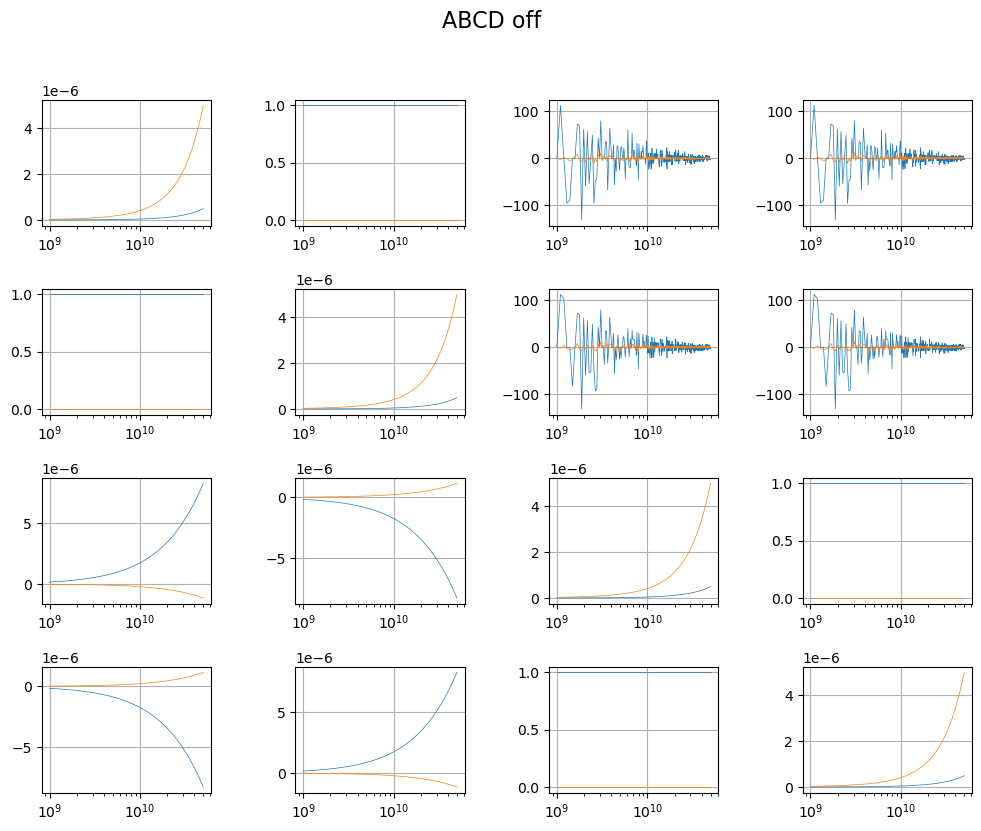

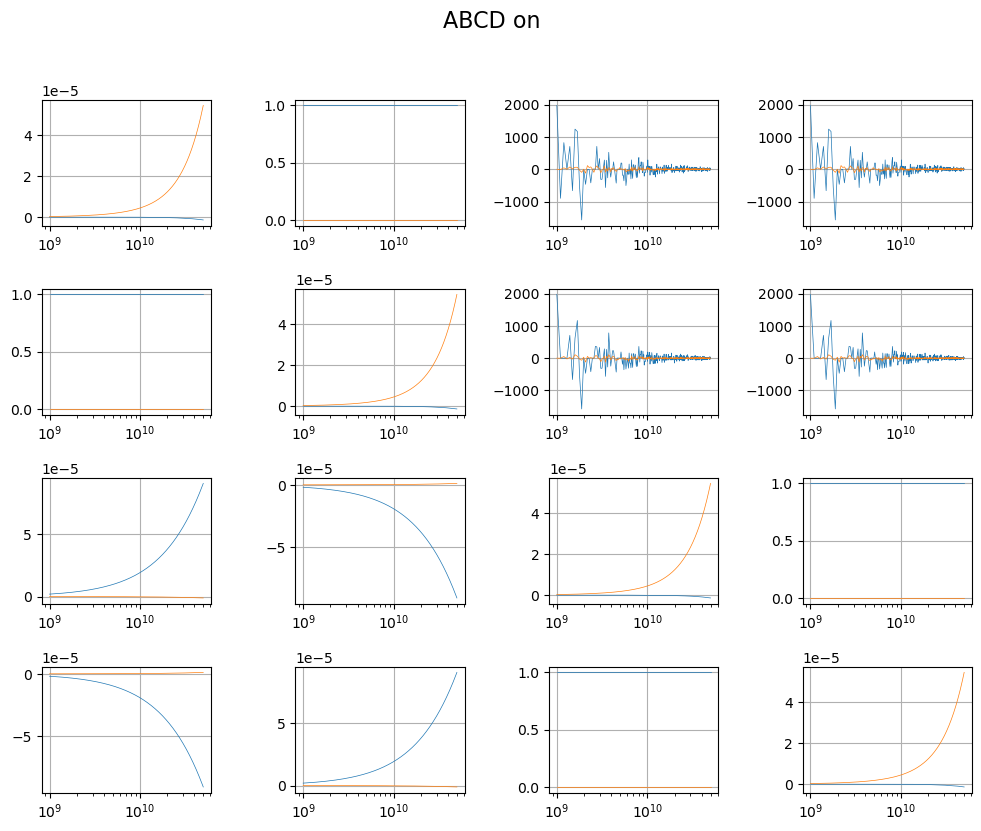

In [95]:
ABCD_off, ABCD_on = Z2ABCDmultiport(Z_off, Z_on, fpoints)
print(np.shape(ABCD_off))
plot_Z_params(f, ABCD_off, "ABCD off")
plot_Z_params(f, ABCD_on, "ABCD on")

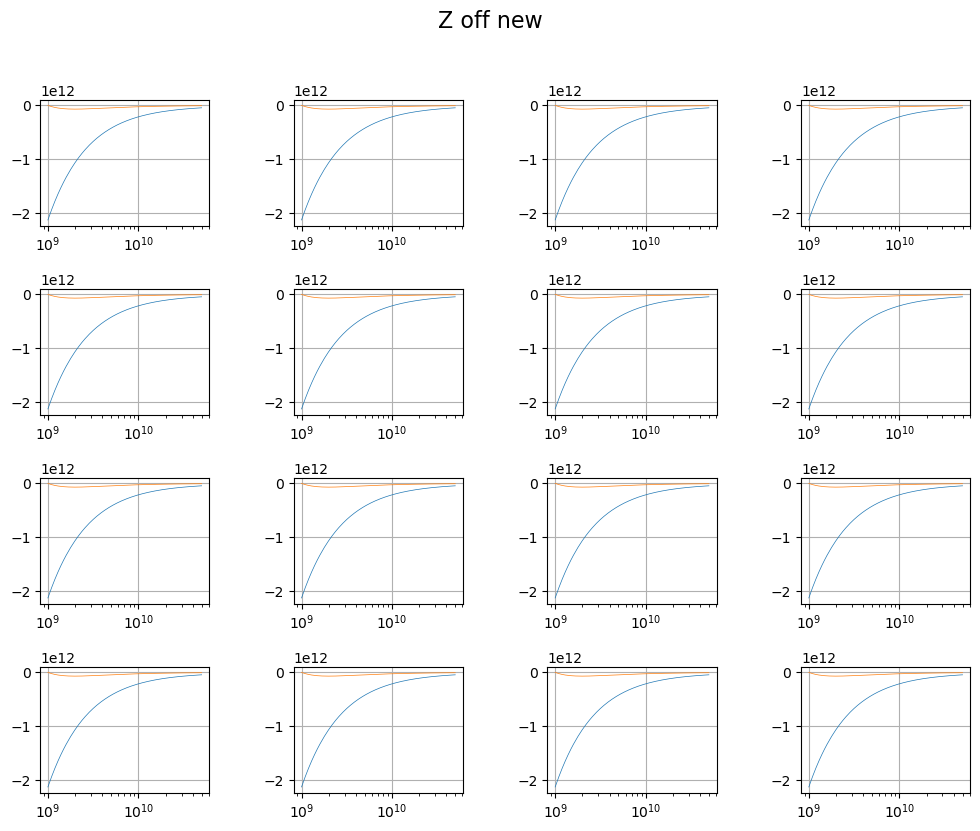

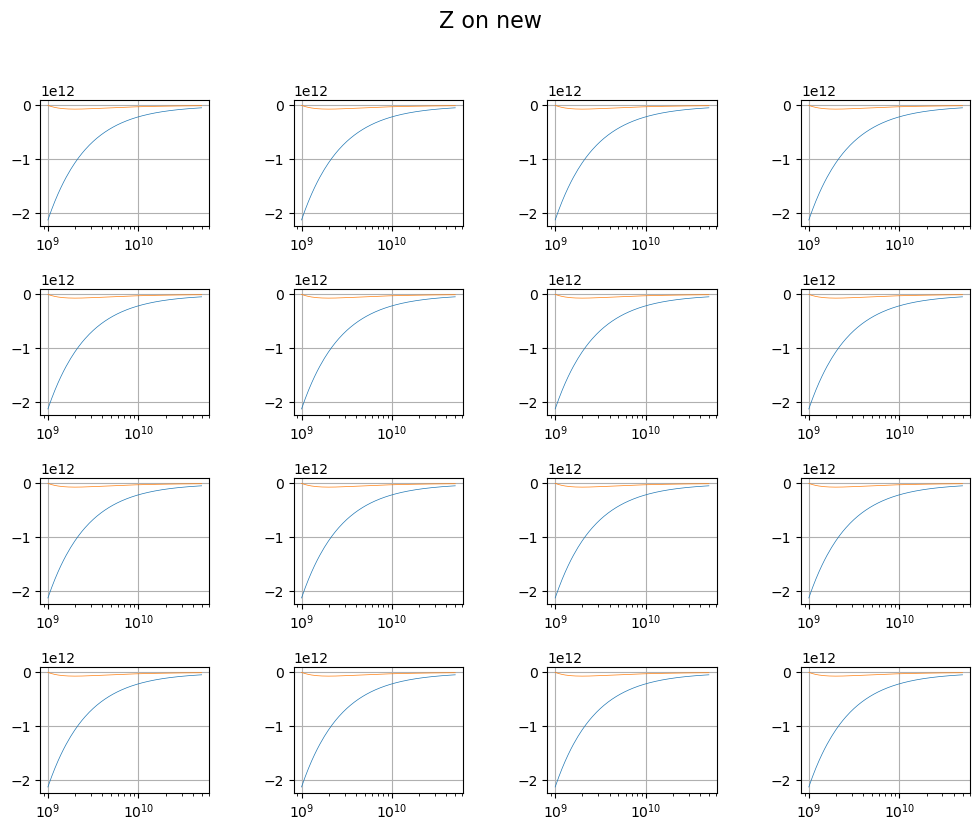

In [96]:
Z_off_new = ABCD2Z(ABCD_off, fpoints)
Z_on_new = ABCD2Z(ABCD_on, fpoints)
plot_Z_params(f, Z_off_new, "Z off new")
plot_Z_params(f, Z_on_new, "Z on new")

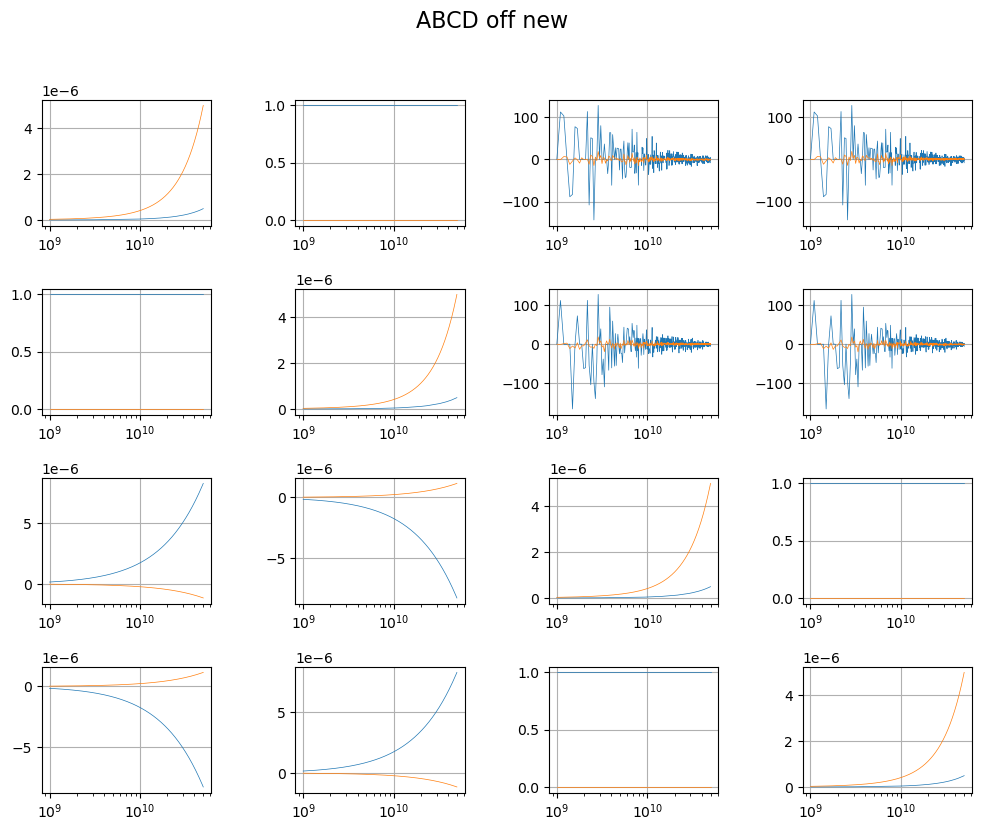

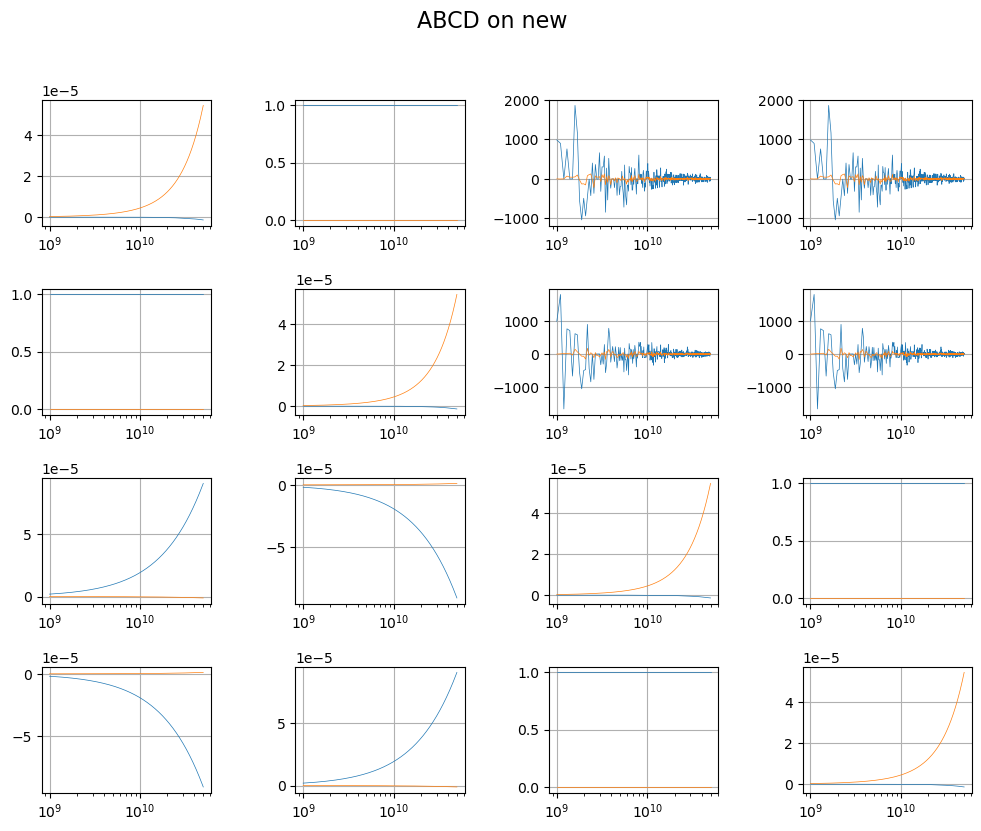

In [97]:
ABCD_off_new, ABCD_on_new = Z2ABCDmultiport(Z_off_new, Z_on_new, fpoints)
plot_Z_params(f, ABCD_off_new, "ABCD off new")
plot_Z_params(f, ABCD_on_new, "ABCD on new")

In [98]:
def Z2S(Z_off, Z_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0(Zin, Zin, Zin, Zin)
    Z0 = create_Z0(Zin, Zin, Zin, Zin)
    S_off = multiply_mat(G0, multiply_mat(Z_off - np.conj(Z0), multiply_mat(invert_mat(Z_off + Z0), invert_mat(G0))))
    S_on = multiply_mat(G0, multiply_mat(Z_on - np.conj(Z0), multiply_mat(invert_mat(Z_on + Z0), invert_mat(G0))))
    return S_off, S_on

def S2Z(S_off, S_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0(Zin, Zin, Zin, Zin)
    Z0 = create_Z0(Zin, Zin, Zin, Zin)
    identity_matrices = []
    for i in range(fpoints):
        identity_matrices.append(np.eye(4))
    I = np.stack(identity_matrices, axis=-1)
    Z_off = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_off)), multiply_mat(S_off, Z0) + np.conj(Z0)), G0)
    Z_on = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_on)), multiply_mat(S_on, Z0) + np.conj(Z0)), G0)
    return Z_off, Z_on

def S2ABCD(S_off, S_on, fpoints):
    Z_off, Z_on = S2Z(S_off, S_on)
    ABCD_off, ABCD_on = Z2ABCDmultiport(Z_off, Z_on, fpoints)
    return ABCD_off, ABCD_on

def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def plot_S_parameters(f, S_off, S_on, title, smooth_window=1):
    gridSize = int(np.ceil(np.sqrt(16)))
    fig_S_params, ax = plt.subplots(gridSize, gridSize, figsize=(15, 9))

    for i in range(16):
        # Smooth the S-parameter data
        smoothed_S_off = moving_average(20*np.log10(np.abs(S_off[int(i/4), i%4, :])), smooth_window)
        smoothed_S_on = moving_average(20*np.log10(np.abs(S_on[int(i/4), i%4, :])), smooth_window)
        line, = ax.flat[i].semilogx(f[:len(smoothed_S_off)], smoothed_S_off)
        line, = ax.flat[i].semilogx(f[:len(smoothed_S_on)], smoothed_S_on)
        ax.flat[i].grid(True)  # Add grid lines

    # Set a common title for all subplots
    fig_S_params.suptitle(title, fontsize=16)

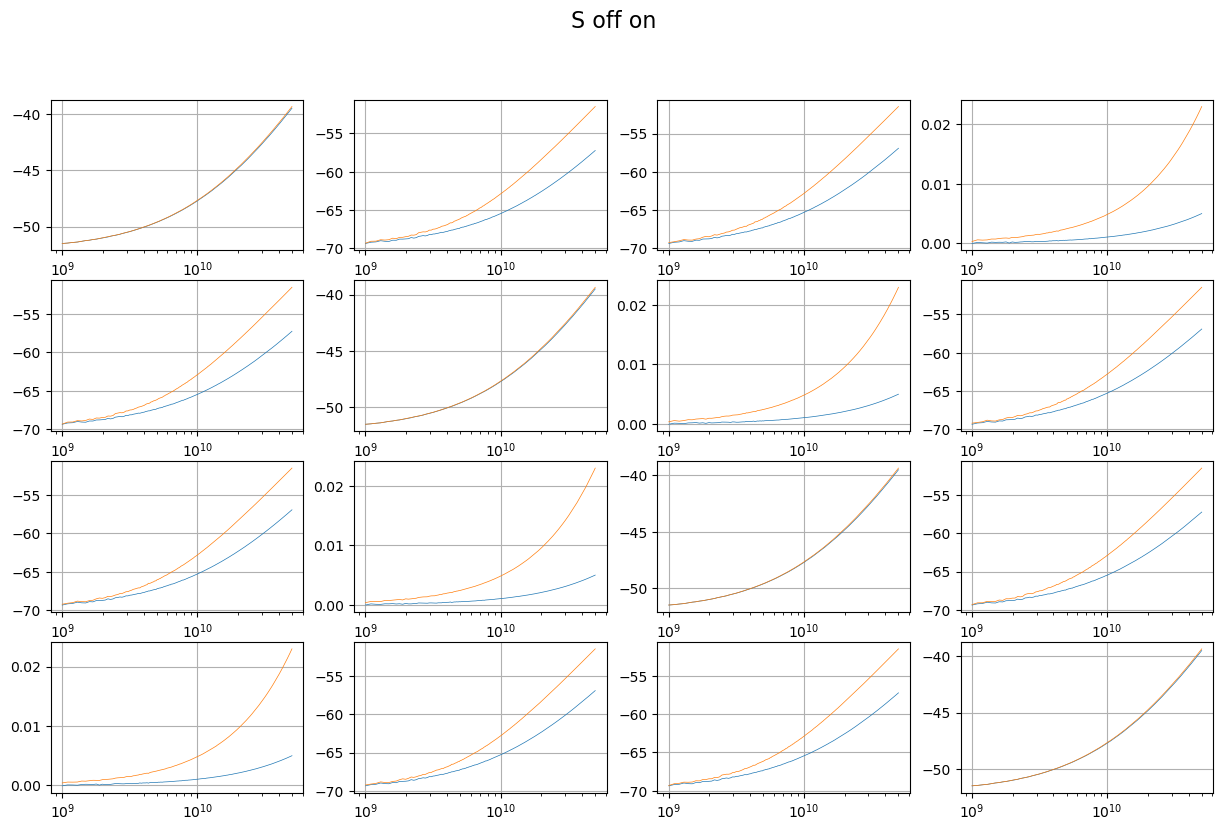

In [99]:
S_off, S_on = Z2S(Z_off, Z_on, fpoints)
plot_S_parameters(f, S_off, S_on, "S off on", smooth_window=1)

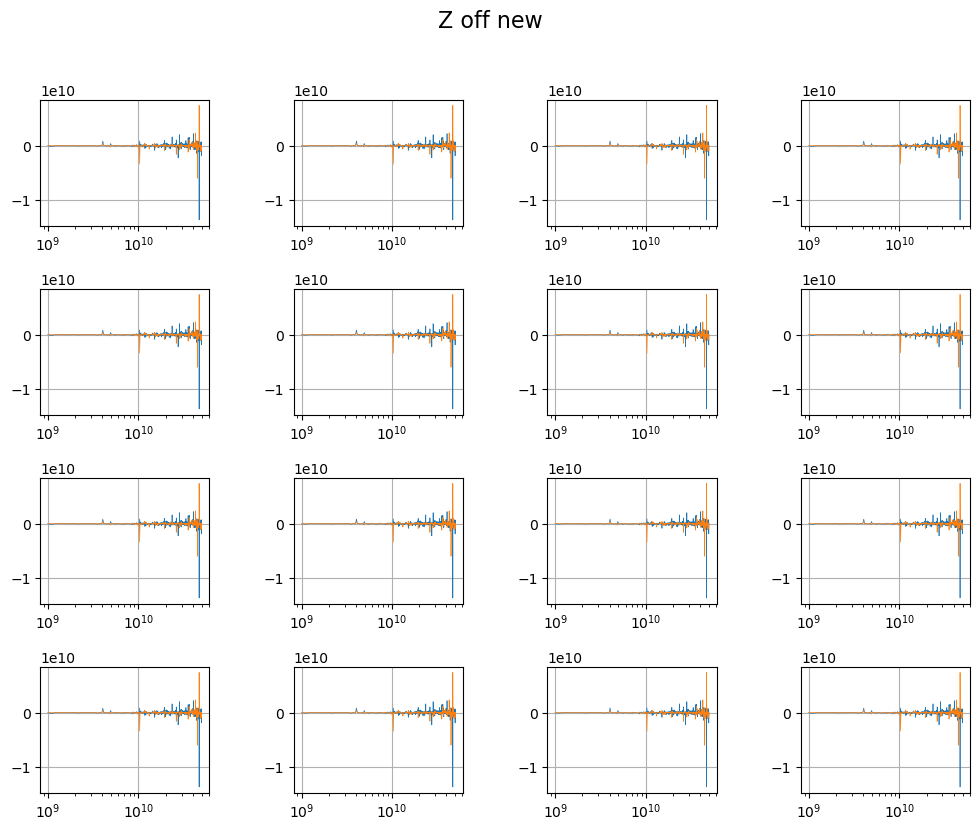

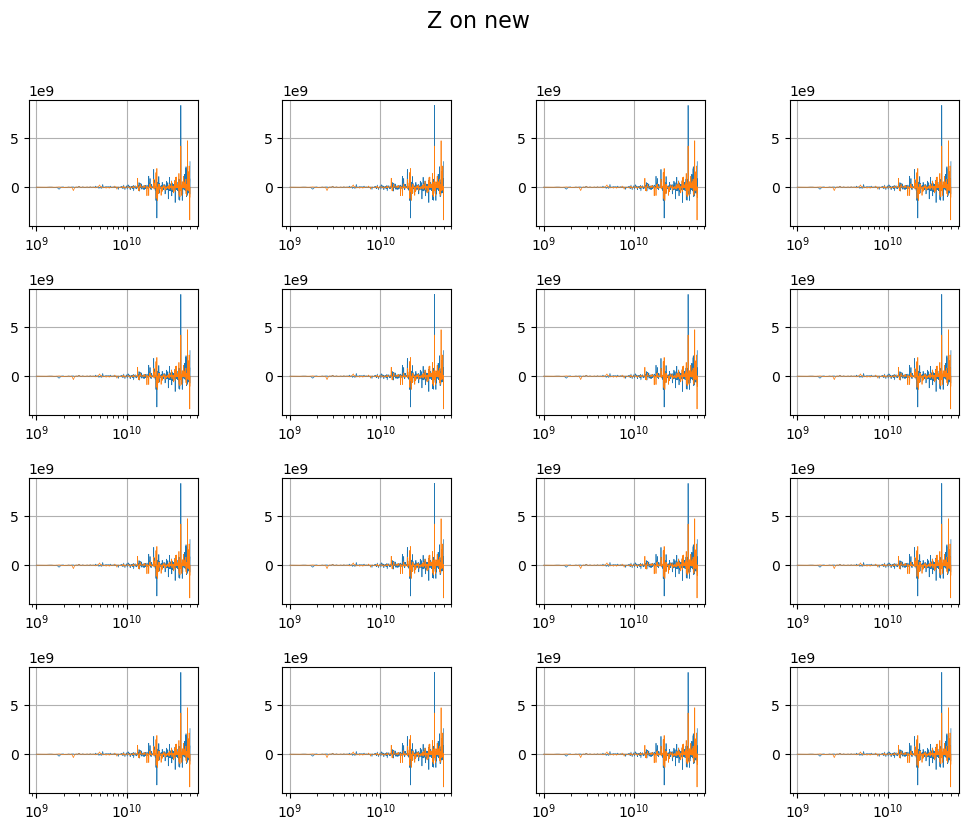

In [100]:
Z_off_new, Z_on_new = S2Z(S_off, S_on, fpoints)
plot_Z_params(f, Z_off_new, "Z off new")
plot_Z_params(f, Z_on_new, "Z on new")

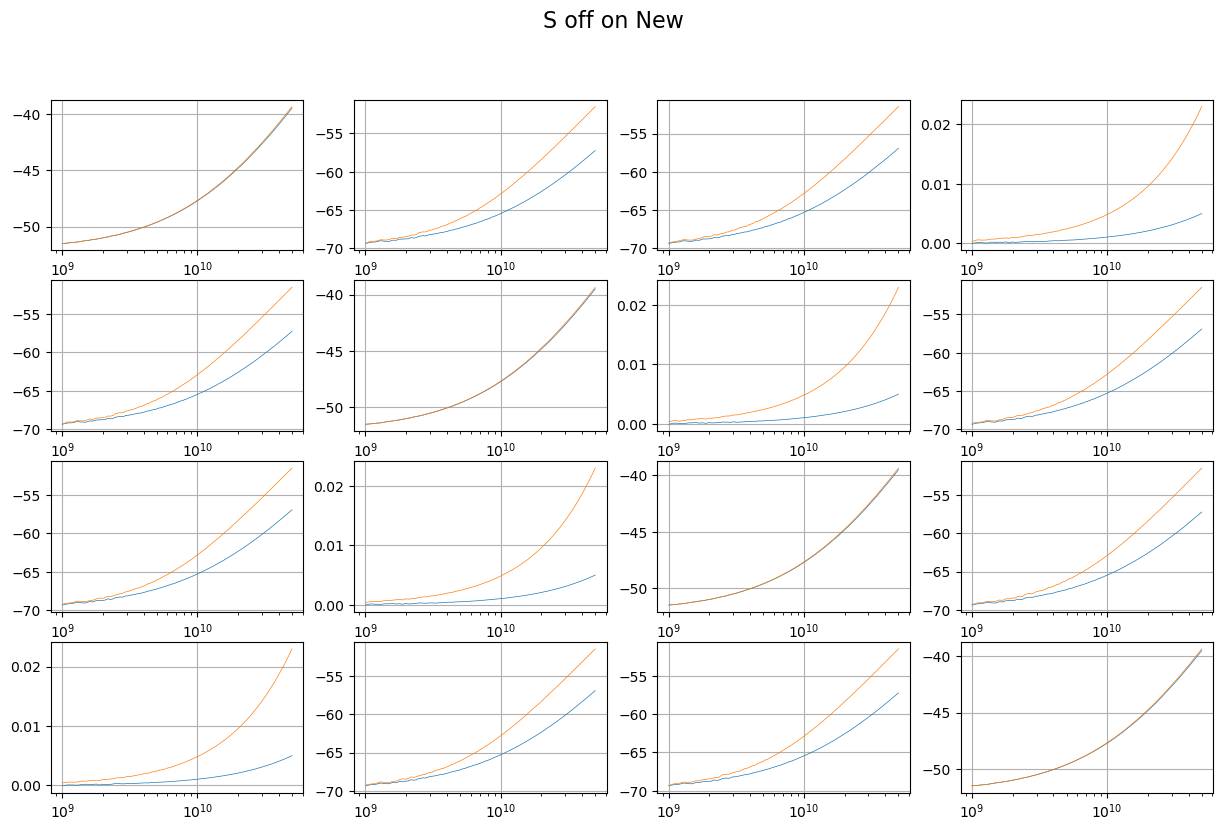

In [101]:
S_off_new, S_on_new = Z2S(Z_off_new, Z_on_new, fpoints)
plot_S_parameters(f, S_off_new, S_on_new, "S off on New", smooth_window=1)

In [102]:
def Z2S_2x2(Z_off, Z_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_2x2(Zin, Zin)
    Z0 = create_Z0_2x2(Zin, Zin)
    S_off = multiply_mat(G0, multiply_mat(Z_off - np.conj(Z0), multiply_mat(invert_mat(Z_off + Z0), invert_mat(G0))))
    S_on = multiply_mat(G0, multiply_mat(Z_on - np.conj(Z0), multiply_mat(invert_mat(Z_on + Z0), invert_mat(G0))))
    return S_off, S_on

def S2Z_2x2(S_off, S_on, fpoints):
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_2x2(Zin, Zin)
    Z0 = create_Z0_2x2(Zin, Zin)
    identity_matrices = []
    for i in range(fpoints):
        identity_matrices.append(np.eye(2))
    I = np.stack(identity_matrices, axis=-1)
    Z_off = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_off)), multiply_mat(S_off, Z0) + np.conj(Z0)), G0)
    Z_on = multiply_mat(multiply_mat(multiply_mat(invert_mat(G0), invert_mat(I-S_on)), multiply_mat(S_on, Z0) + np.conj(Z0)), G0)
    return Z_off, Z_on
    

def Z2ABCD_2x2(Z_off, Z_on, fpoints):
    Zee_off = Z_off[0, 0, :]
    Zei_off = Z_off[0, 1, :]
    Zie_off = Z_off[1, 0, :]
    Zii_off = Z_off[1, 1, :]

    Zee_on = Z_on[0, 0, :]
    Zei_on = Z_on[0, 1, :]
    Zie_on = Z_on[1, 0, :]
    Zii_on = Z_on[1, 1, :]

    ABCD_off = np.zeros((2, 2, fpoints), dtype=complex)
    ABCD_on = np.zeros((2, 2, fpoints), dtype=complex)

    ABCD_off[0, 0, :] = Zee_off/Zie_off
    ABCD_off[0, 1, :] = Zee_off*Zii_off/Zie_off - Zei_off
    ABCD_off[1, 0, :] = 1/Zie_off
    ABCD_off[1, 1, :] = Zii_off/Zie_off

    ABCD_on[0, 0, :] = Zee_on/Zie_on
    ABCD_on[0, 1, :] = Zee_on*Zii_on/Zie_on - Zei_on
    ABCD_on[1, 0, :] = 1/Zie_on
    ABCD_on[1, 1, :] = Zii_on/Zie_on

    return ABCD_off, ABCD_on

def ABCD2Z_2x2(ABDC_off, ABCD_on, fpoints):
    Z_off = np.zeros((2, 2, fpoints), dtype=ABDC_off.dtype)
    Z_on = Z_off
    Zin = 50 * np.ones(fpoints)
    G0 = create_G0_2x2(Zin, Zin)
    Z0 = create_Z0_2x2(Zin, Zin)

    A_off = ABCD_off[0, 0, :]
    B_off = ABCD_off[0, 1, :]
    C_off = ABCD_off[1, 0, :]
    D_off = ABCD_off[1, 1, :]

    Z_off[0:2, 0:2, :] = A_off/C_off
    Z_off[0:2, 2:4, :] = A_off*D_off/C_off - B_off
    Z_off[2:4, 0:2, :] = 1/C_off
    Z_off[2:4, 2:4, :] = D_off/C_off

    A_on = ABCD_on[0, 0, :]
    B_on = ABCD_on[0, 1, :]
    C_on = ABCD_on[1, 0, :]
    D_on = ABCD_on[1, 1, :]

    Z_on[0:2, 0:2, :] = A_on/C_on
    Z_on[0:2, 2:4, :] = A_on*D_on/C_on - B_on
    Z_on[2:4, 0:2, :] = 1/C_on
    Z_on[2:4, 2:4, :] = D_on/C_on

    return Z_off, Z_on

def S2ABCD_2x2(S_off, S_on, fpoints):
    Z_off, Z_on = S2Z_2x2(S_off, S_on, fpoints)
    return Z2ABCD_2x2(Z_off, Z_on, fpoints)

def ABCD2S_2x2(ABCD_off, ABCD_on, fpoints):
    Z_off, Z_on = ABCD2Z_2x2(ABCD_off, ABCD_on, fpoints)
    return Z2S_2x2(Z_off, Z_on, fpoints)
